In [5]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Simulation parameters
resolution = 10  # pixels/um
pml_thickness = 2
cell_x = 16
cell_y = 16
cell_z = 16

sphere_radius = 1.0
sphere_eps = 2.56
substrate_eps = 2.56
frequency = 1.0

cell_size = mp.Vector3(cell_x, cell_y, cell_z)

# Plane wave incidence defined by polar and azimuthal angles (in degrees)
theta_deg = 10  # Polar angle from +Z
phi_deg = 0    # Azimuthal angle in x–y plane

# Convert to radians
theta = np.radians(theta_deg)
phi = np.radians(phi_deg)

# Build normalized k-vector
k_unit = mp.Vector3(
    np.sin(theta) * np.cos(phi),
    np.sin(theta) * np.sin(phi),
    -np.cos(theta)  # negative for downward propagation
)

# Scale for Meep's eig_kpoint (|k| = frequency in Meep units)
eig_kpoint = k_unit.scale(frequency)


In [7]:
# Materials
default_material = mp.Medium(index=1.0)
sphere = mp.Sphere(
    center=mp.Vector3(0, 0, 1.5),  # place above substrate
    radius=sphere_radius,
    material=mp.Medium(epsilon=sphere_eps)
)

substrate = mp.Block(
    center=mp.Vector3(0, 0, -cell_z/4),
    size=mp.Vector3(mp.inf, mp.inf, cell_z/2),
    material=mp.Medium(epsilon=substrate_eps)
)

geometry = [sphere, substrate]

# Source: downward plane wave at angles
sources = [
    mp.EigenModeSource(
        src=mp.ContinuousSource(frequency=frequency),
        center=mp.Vector3(0, 0, 0.5 * cell_z - pml_thickness - 1),
        size=mp.Vector3(cell_x, cell_y, 0),
        direction=mp.Z,  # still Z, but mode defines propagation
        eig_kpoint=eig_kpoint,
        eig_band=1,
        eig_match_freq=True
    )
]


# PMLs on all sides
pml_layers = [
    mp.PML(thickness=pml_thickness, direction=mp.X),
    mp.PML(thickness=pml_thickness, direction=mp.Y),
    mp.PML(thickness=pml_thickness, direction=mp.Z),
]

# Simulation object
sim = mp.Simulation(
    cell_size=cell_size,
    resolution=resolution,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    default_material=default_material
)

# Add flux monitors (six directions)
flux_regions = {
    'top':    mp.FluxRegion(center=mp.Vector3(0, 0, 0.5*cell_z - pml_thickness - 0.1), size=mp.Vector3(cell_x, cell_y, 0)),
    'bottom': mp.FluxRegion(center=mp.Vector3(0, 0, -0.5*cell_z + pml_thickness + 0.1), size=mp.Vector3(cell_x, cell_y, 0)),
    'left':   mp.FluxRegion(center=mp.Vector3(-0.5*cell_x + pml_thickness + 0.1, 0, 0), size=mp.Vector3(0, cell_y, cell_z)),
    'right':  mp.FluxRegion(center=mp.Vector3(0.5*cell_x - pml_thickness - 0.1, 0, 0), size=mp.Vector3(0, cell_y, cell_z)),
    'front':  mp.FluxRegion(center=mp.Vector3(0, -0.5*cell_y + pml_thickness + 0.1, 0), size=mp.Vector3(cell_x, 0, cell_z)),
    'back':   mp.FluxRegion(center=mp.Vector3(0, 0.5*cell_y - pml_thickness - 0.1, 0), size=mp.Vector3(cell_x, 0, cell_z)),
}

flux_monitors = {name: sim.add_flux(frequency, 0, 1, region)
                 for name, region in flux_regions.items()}

# Run the simulation
sim.run(until=60)


-----------
Initializing structure...
time for choose_chunkdivision = 0.00201392 s
Working in 3D dimensions.
Computational cell is 16 x 16 x 16 with resolution 10
     sphere, center = (0,0,1.5)
          radius 1
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
     block, center = (0,0,-4)
          size (1e+20,1e+20,8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
time for set_epsilon = 20.3366 s
-----------
MPB solved for frequency_1(0.00174533,0,-0.999998) = 1 after 108 iters
Meep progress: 0.05/60.0 = 0.1% done in 9.7s, 11602.8s to go
on time step 1 (time=0.05), 9.67748 s/step
Meep progress: 1.1500000000000001/60.0 = 1.9% done in 13.8s, 708.2s to go
on time step 23 (time=1.15), 0.189032 s/step
Meep progress: 2.25/60.0 = 3.8% done in 18.0s, 462.1s to go
on time step 45 (time=2.25), 0.189326 s/step
Meep progress: 3.35/60.0 = 5.6% done in 22.2s, 375.1s to go
on time step 67 (time=3.35), 0.18975 s/step
Meep

Flux through top: 16.750088
Flux through bottom: -269.144053
Flux through left: 5.055997
Flux through right: -4.141258
Flux through front: 4.448790
Flux through back: -4.556856


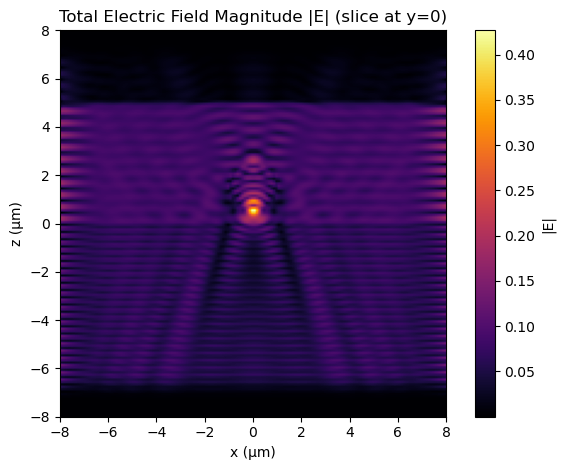

: 

In [ ]:
# Print flux values
for name, monitor in flux_monitors.items():
    flux_val = mp.get_fluxes(monitor)[0]
    print(f"Flux through {name}: {flux_val:.6f}")

# Get all field components for total |E| calculation
ex = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, 0, cell_z), component=mp.Ex)
ey = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, 0, cell_z), component=mp.Ey)
ez = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, 0, cell_z), component=mp.Ez)

abs_E = np.sqrt(np.abs(ex)**2 + np.abs(ey)**2 + np.abs(ez)**2)

# Plot total field magnitude
plt.figure(dpi=100)
plt.imshow(abs_E.T, cmap='inferno', origin='lower', extent=[-cell_x/2, cell_x/2, -cell_z/2, cell_z/2])
plt.colorbar(label='|E|')
plt.xlabel('x (µm)')
plt.ylabel('z (µm)')
plt.title('Total Electric Field Magnitude |E| (slice at y=0)')
plt.tight_layout()
plt.show()